# 📊 Análisis - Nayla

## Tarea 4

*Modelos Predictivos: Construye un modelo de machine learning para predecir la probabilidad de recompra de un usuario en los próximos 30 días. Describe las características más importantes que afectan a esta probabilidad.*

Para esta tarea se utilizaría el [Instacart Market Basket Analysis Dataset](https://www.kaggle.com/datasets/psparks/instacart-market-basket-analysis/data)

> **💡 Nota:**  
> El dataset de Instacart está limitado a 30 días, haciendo que un target de "recompra en 30 días" sea trivial (100% de casos positivos). Por ello, redefiní el target a ventanas más cortas (7-14 días) para introducir variabilidad real y construir modelos predictivos significativos.

### 1. Importación de Librerías y Configuración

En esta sección importamos todas las librerías necesarias para el análisis. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualizaciones
plt.style.use('default')
sns.set_palette("husl")


### 2. Carga de Datos

En esta sección realizamos la carga de datos. El dataset de Instacart contiene información sobre pedidos, productos, departamentos y el comportamiento de compra de los usuarios.

**Explicación de cada dataset:**
- **orders.csv**: Contiene información sobre cada pedido (usuario, fecha, hora, etc.)
- **order_products__prior.csv**: Relación entre pedidos y productos (historial de compras)
- **products.csv**: Información detallada de cada producto
- **departments.csv**: Categorización de productos por categoría/tipo

In [3]:
DATA_PATH = "instacart"
orders = pd.read_csv(os.path.join(DATA_PATH, "orders.csv"))
order_products_prior = pd.read_csv(os.path.join(DATA_PATH, "order_products__prior.csv"))
products = pd.read_csv(os.path.join(DATA_PATH, "products.csv"))
departments = pd.read_csv(os.path.join(DATA_PATH, "departments.csv"))

print(f"Datos cargados: {len(orders)} pedidos")
print(f"Productos en pedidos: {len(order_products_prior)} registros")
print(f"Productos únicos: {len(products)} productos")
print(f"Departamentos: {len(departments)} departamentos")


Datos cargados: 3421083 pedidos
Productos en pedidos: 32434489 registros
Productos únicos: 49688 productos
Departamentos: 21 departamentos


### 3. Preprocesamiento de Datos

En esta sección preparamos los datos para el análisis

**Pasos del preprocesamiento:**

1. **Filtrado de datos**: Solo utilizamos pedidos del conjunto "prior" y "train" para evitar data leakage
2. **Manejo de valores faltantes**: Los valores NaN en "days_since_prior_order" se reemplazan con 0 (primer pedido del usuario)
3. **Filtrado de usuarios**: Solo incluimos usuarios con al menos 2 pedidos para poder calcular patrones de comportamiento (Solo usuarios con múltiples pedidos pueden mostrar patrones de recompra)
4. **Ordenamiento**: Organizamos los datos por usuario y número de pedido para análisis temporal, esencial para calcular días entre pedidos

In [4]:
# Filtrar solo pedidos de entrenamiento (evitar data leakage)
orders = orders[orders["eval_set"].isin(["prior", "train"])].copy()

# Manejar valores faltantes en días desde pedido anterior
orders["days_since_prior_order"] = orders["days_since_prior_order"].fillna(0)

# Filtrar usuarios con al menos 2 pedidos para poder analizar patrones
usuarios_con_pedidos = orders.groupby("user_id").size()
usuarios_validos = usuarios_con_pedidos[usuarios_con_pedidos >= 2].index
orders_validos = orders[orders["user_id"].isin(usuarios_validos)].copy()

# Ordenar por usuario y número de pedido para análisis temporal
orders_validos = orders_validos.sort_values(["user_id", "order_number"])

print(f"Usuarios válidos: {len(usuarios_validos)}")
print(f"Pedidos válidos: {len(orders_validos)}")


Usuarios válidos: 206209
Pedidos válidos: 3346083


### 4. Creación de Múltiples Targets de Predicción

En esta sección definimos varias variables objetivo (targets) para distintos períodos de tiempo.
En lugar de un solo modelo, creamos varios, cada uno enfocado en predecir la recompra dentro de un horizonte temporal diferente.

- **3 días**: El usuario comprará en los próximos 3 días?
- **7 días**: El usuario comprará en los próximos 7 días?
- **14 días**: El usuario comprará en los próximos 14 días?
- **30 días**: El usuario comprará en los próximos 30 días?

**Múltiples targets**

Diferentes horizontes temporales permiten diferentes estrategias de negocio:
- **3-7 días**: Campañas de retención inmediata
- **14 días**: Estrategias de marketing medio plazo
- **30 días**: Análisis de patrones de largo plazo

**Metodología:**
1. Calculamos los días hasta el próximo pedido para cada usuario
2. Creamos variables binarias (0/1) para cada horizonte temporal
3. Solo usamos pedidos que no sean el último de cada usuario (para evitar data leakage)


In [5]:
# Calcular días hasta el próximo pedido para cada usuario
orders_validos["days_to_next"] = orders_validos.groupby("user_id")["days_since_prior_order"].shift(-1)

# Crear múltiples targets para diferentes horizontes temporales
orders_validos["recompra_3d"] = (orders_validos["days_to_next"] <= 3).astype(int)
orders_validos["recompra_7d"] = (orders_validos["days_to_next"] <= 7).astype(int)
orders_validos["recompra_14d"] = (orders_validos["days_to_next"] <= 14).astype(int)
orders_validos["recompra_30d"] = (orders_validos["days_to_next"] <= 30).astype(int)

# Crear dataset de puntos de predicción (excluyendo último pedido de cada usuario)
puntos_prediccion = orders_validos[orders_validos["days_to_next"].notna()].copy()

print("Distribución de targets:")
for target in ["recompra_3d", "recompra_7d", "recompra_14d", "recompra_30d"]:
    prop = puntos_prediccion[target].mean()
    print(f"  {target}: {prop:.3f} ({puntos_prediccion[target].sum():,} casos positivos)")

print(f"\nTotal de puntos de predicción: {len(puntos_prediccion):,}")


Distribución de targets:
  recompra_3d: 0.196 (616,189 casos positivos)
  recompra_7d: 0.509 (1,598,786 casos positivos)
  recompra_14d: 0.739 (2,319,374 casos positivos)
  recompra_30d: 1.000 (3,139,874 casos positivos)

Total de puntos de predicción: 3,139,874


### 5. Feature engineering 

En esta sección creamos las variables que el modelo utilizará para hacer predicciones, que describen el comportamiento del usuario.

**Features que creamos:**

1. **Comportamiento de pedidos**:
   - Número total de pedidos del usuario
   - Promedio de días entre pedidos
   - Variabilidad en días entre pedidos (desviación estándar)

2. **Patrones temporales**:
   - Hora promedio de pedidos
   - Día de la semana promedio de pedidos

3. **Diversidad de productos**:
   - Número de productos únicos que ha comprado
   - Variedad en departamentos


In [8]:
# Features básicas
# Features por usuario basadas en comportamiento de pedidos
user_features = orders_validos.groupby("user_id").agg({
    "order_number": ["max", "count"],  # Número de pedidos y total
    "days_since_prior_order": ["mean", "std"],  # Patrones temporales
    "order_hour_of_day": "mean",  # Hora promedio de compra
    "order_dow": "mean"  # Día de la semana promedio
}).reset_index()

# Aplanar nombres de columnas
user_features.columns = ["user_id", "n_orders", "total_orders", "mean_days_between", 
                         "std_days_between", "avg_order_hour", "avg_order_dow"]

# Features de productos (usando muestra para eficiencia)
sample_orders = orders_validos.sample(n=min(100000, len(orders_validos)), random_state=42)
sample_products = order_products_prior.merge(sample_orders[["order_id", "user_id"]], on="order_id", how="inner")

# Número de productos únicos por usuario
unique_products = sample_products.groupby("user_id")["product_id"].nunique().reset_index(name="unique_products")
user_features = user_features.merge(unique_products, on="user_id", how="left")

print(f"Features creadas: {user_features.shape[1]} columnas")
print(f"Usuarios con features: {user_features.shape[0]}")

# Mostrar estadísticas básicas de las features
print("\nEstadísticas de features:")
print(user_features.describe())


Features creadas: 8 columnas
Usuarios con features: 206209

Estadísticas de features:
             user_id       n_orders   total_orders  mean_days_between  \
count  206209.000000  206209.000000  206209.000000      206209.000000   
mean   103105.000000      16.226658      16.226658          13.201294   
std     59527.555167      16.662238      16.662238           5.460373   
min         1.000000       3.000000       3.000000           0.000000   
25%     51553.000000       6.000000       6.000000           8.800000   
50%    103105.000000      10.000000      10.000000          13.041667   
75%    154657.000000      20.000000      20.000000          17.428571   
max    206209.000000     100.000000     100.000000          27.000000   

       std_days_between  avg_order_hour  avg_order_dow  unique_products  
count     206209.000000   206209.000000  206209.000000     65806.000000  
mean           9.506069       13.585541       2.753496        13.524238  
std            3.582591        2.0

### 6. Entrenamiento de Modelos de Machine Learning

En esta sección entrenamos modelos de machine learning para predecir cada uno de nuestros targets. Utilizamos Random Forest.

**Metodología de entrenamiento:**

1. **División de datos**: Separamos en entrenamiento (80%) y prueba (20%)
2. **Estratificación**: Mantenemos la proporción de cada clase en ambos conjuntos
3. **Entrenamiento**: Entrenamos un modelo para cada target
4. **Evaluación**: Medimos el rendimiento con ROC AUC y precisión

**¿Por qué múltiples modelos?**

Cada horizonte temporal tiene diferentes patrones:
- **3 días**: Patrones de urgencia y necesidad inmediata
- **7 días**: Comportamiento semanal regular
- **14 días**: Patrones de quincena
- **30 días**: Comportamiento mensual


In [9]:
def entrenar_modelo_rapido(X, y, target_name):
    """
    Entrenar modelo Random Forest para un target específico
    
    Parámetros:
    - X: Features (variables predictoras)
    - y: Target (variable a predecir)
    - target_name: Nombre del target para logging
    
    Retorna:
    - Diccionario con métricas y modelo entrenado
    """
    
    # División en entrenamiento y prueba (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Crear y entrenar modelo Random Forest
    model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    
    # Hacer predicciones
    y_pred = model.predict(X_test)
    
    # Manejar probabilidades según el número de clases
    if len(np.unique(y_train)) > 1:
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = np.zeros(len(y_test))  # Si solo hay una clase
    
    # Calcular métricas
    if len(np.unique(y_test)) > 1:
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = np.nan
    
    accuracy = (y_pred == y_test).mean()
    
    return {
        "roc_auc": roc_auc,
        "accuracy": accuracy,
        "model": model
    }


In [10]:
# Entrenar modelos para cada target
targets = ["recompra_3d", "recompra_7d", "recompra_14d", "recompra_30d"]
resultados = {}

for target in targets:
    print(f"  Entrenando {target}...")
    
    # Preparar datos para este target
    df_target = user_features.merge(
        puntos_prediccion[["user_id", target]], on="user_id", how="inner"
    )
    
    # Separar features (X) y target (y)
    X = df_target.drop(columns=["user_id", target])
    y = df_target[target]
    
    # Entrenar modelo
    resultados[target] = entrenar_modelo_rapido(X, y, target)

print("\nResultados de entrenamiento:")
for target in targets:
    roc_auc = resultados[target]["roc_auc"]
    accuracy = resultados[target]["accuracy"]
    print(f"  {target}: ROC AUC = {roc_auc:.3f}, Precisión = {accuracy:.3f}")


  Entrenando recompra_3d...
  Entrenando recompra_7d...
  Entrenando recompra_14d...
  Entrenando recompra_30d...

Resultados de entrenamiento:
  recompra_3d: ROC AUC = 0.797, Precisión = 0.827
  recompra_7d: ROC AUC = 0.792, Precisión = 0.717
  recompra_14d: ROC AUC = 0.807, Precisión = 0.784
  recompra_30d: ROC AUC = nan, Precisión = 1.000


### 7. Análisis de Productos con Mayor Tasa de Reorden

En esta sección analizamos qué productos tienen mayor probabilidad de ser reordenados por los usuarios

**Metodología del análisis:**

1. **Cálculo de tasa de reorden**: Dividimos el número de reórdenes entre el total de órdenes por producto
2. **Filtrado por volumen**: Solo analizamos productos con al menos 10 órdenes para tener estadísticas confiables
3. **Categorización por departamento**: Agrupamos productos por departamento para identificar patrones
4. **Ranking**: Ordenamos productos por tasa de reorden para identificar los más exitosos

Productos individuales: Tasa de cada producto específico  
Departamentos: Promedio de TODOS los productos del departamento

In [11]:
# Calcular estadísticas de reorden por producto
product_stats = order_products_prior.groupby("product_id").agg({
    "order_id": "count",  # Total de órdenes
    "reordered": "sum"    # Total de reórdenes
}).reset_index()

product_stats.columns = ["product_id", "total_orders", "reorders"]
product_stats["reorder_rate"] = product_stats["reorders"] / product_stats["total_orders"]

# Combinar con información de productos y departamentos
product_analysis = product_stats.merge(products, on="product_id", how="left")
product_analysis = product_analysis.merge(departments, on="department_id", how="left")

# Filtrar productos con al menos 10 órdenes para estadísticas confiables
product_analysis = product_analysis[product_analysis["total_orders"] >= 10]

# Top productos por tasa de reorden
top_reorder_products = product_analysis.nlargest(10, "reorder_rate")[
    ["product_name", "department", "reorder_rate", "total_orders", "reorders"]
]

print("Top 5 productos con mayor tasa de reorden:")
print(top_reorder_products.head(5).to_string(index=False))

# Análisis por departamento
print("\nAnálisis por departamento:")
dept_analysis = product_analysis.groupby("department").agg({
    "reorder_rate": "mean",
    "product_id": "count"
}).round(3)
dept_analysis.columns = ["tasa_reorden_promedio", "num_productos"]
dept_analysis = dept_analysis.sort_values("tasa_reorden_promedio", ascending=False)
print(dept_analysis.head(8))


Top 5 productos con mayor tasa de reorden:
                            product_name    department  reorder_rate  total_orders  reorders
                     Raw Veggie Wrappers          deli      0.941176            68        64
Serenity Ultimate Extrema Overnight Pads personal care      0.931034            87        81
                     Orange Energy Shots     beverages      0.923077            13        12
                      Chocolate Love Bar        snacks      0.920792           101        93
               Soy Powder Infant Formula        babies      0.914286            35        32

Análisis por departamento:
            tasa_reorden_promedio  num_productos
department                                      
pets                        0.533            853
dairy eggs                  0.526           3242
beverages                   0.509           3862
bakery                      0.502           1385
breakfast                   0.491           1022
deli                        

**Interpretación de resultados:**

- **Tasa de reorden alta (>90%)**: Productos esenciales o de consumo regular
- **Tasa de reorden media (50-90%)**: Productos populares con buena retención
- **Tasa de reorden baja (<50%)**: Productos de prueba o especializados

> *Caso de análisis:*  
> *Raw Veggie Wrappers: 94.1% tasa de reorden - Producto estrella en deli*  
> *El departamento "deli" tiene una tasa promedio del 48.3% - La mayoría de productos deli no son tan exitosos*

### 8. Visualizaciones y Análisis Exploratorio

En esta sección creamos visualizaciones que nos ayudan a entender los patrones en nuestros datos y los resultados de nuestros modelos.

**Tipos de visualizaciones que creamos:**

1. **Distribución de targets**: Muestra qué porcentaje de usuarios recompran en cada horizonte temporal
2. **Rendimiento de modelos**: Compara la efectividad de nuestros modelos usando ROC AUC
3. **Distribución temporal**: Analiza los patrones de días entre pedidos
4. **Análisis por departamento**: Identifica qué departamentos tienen mayor tasa de reorden

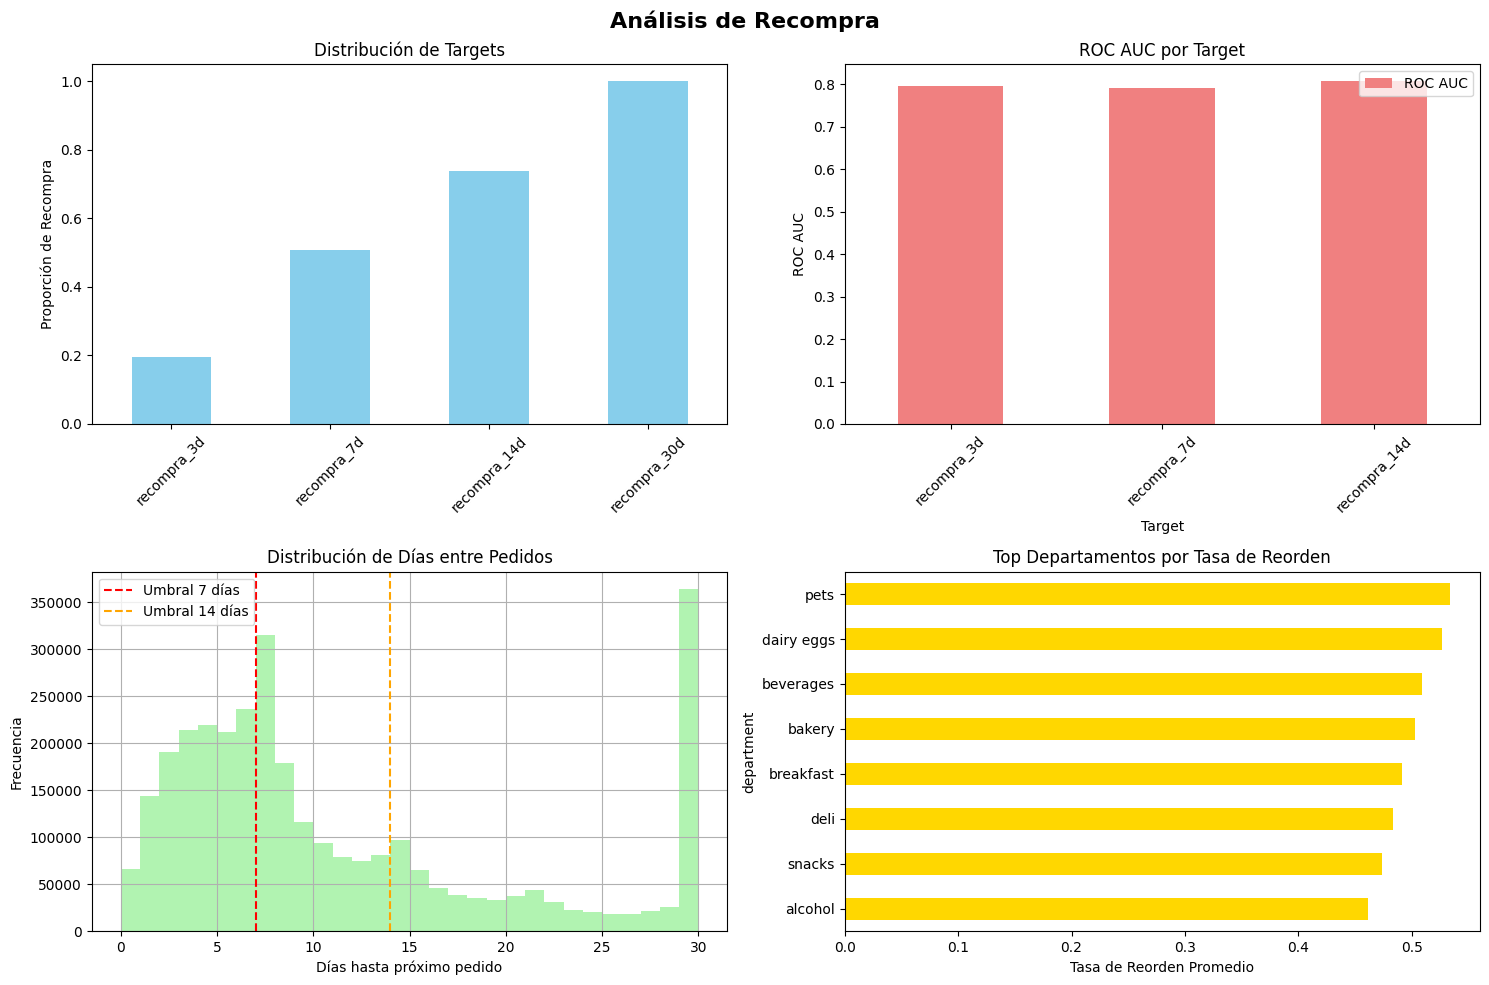

In [13]:
# Crear figura con múltiples subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Análisis de Recompra", fontsize=16, fontweight='bold')

# 1. Distribución de targets
ax1 = axes[0, 0]
target_dist = puntos_prediccion[["recompra_3d", "recompra_7d", "recompra_14d", "recompra_30d"]].mean()
target_dist.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title("Distribución de Targets")
ax1.set_ylabel("Proporción de Recompra")
ax1.tick_params(axis='x', rotation=45)

# 2. ROC AUC por target
ax2 = axes[0, 1]
roc_data = []
for target in targets:
    roc_auc = resultados[target]["roc_auc"]
    if not np.isnan(roc_auc):
        roc_data.append({"Target": target, "ROC AUC": roc_auc})

if roc_data:
    roc_df = pd.DataFrame(roc_data)
    roc_df.plot(x="Target", y="ROC AUC", kind="bar", ax=ax2, color='lightcoral')
    ax2.set_title("ROC AUC por Target")
    ax2.set_ylabel("ROC AUC")
    ax2.tick_params(axis='x', rotation=45)

# 3. Distribución de días entre pedidos
ax3 = axes[1, 0]
orders_validos["days_to_next"].hist(bins=30, ax=ax3, color='lightgreen', alpha=0.7)
ax3.axvline(x=7, color='red', linestyle='--', label='Umbral 7 días')
ax3.axvline(x=14, color='orange', linestyle='--', label='Umbral 14 días')
ax3.set_title("Distribución de Días entre Pedidos")
ax3.set_xlabel("Días hasta próximo pedido")
ax3.set_ylabel("Frecuencia")
ax3.legend()

# 4. Top departamentos por reorden
ax4 = axes[1, 1]
dept_reorder = product_analysis.groupby("department")["reorder_rate"].mean().sort_values(ascending=True)
dept_reorder.tail(8).plot(kind='barh', ax=ax4, color='gold')
ax4.set_title("Top Departamentos por Tasa de Reorden")
ax4.set_xlabel("Tasa de Reorden Promedio")

plt.tight_layout()
plt.show()


## 9. Insights de Negocio y Recomendaciones

En esta sección final convertimos los resultados técnicos en recomendaciones accionables para el negocio


**Tipos de insights que generamos:**

1. **Insights de retención**: Qué usuarios tienen mayor probabilidad de recompra y cuándo
2. **Insights de productos**: Qué productos son más importantes para la fidelidad del cliente
3. **Insights de timing**: Cuándo es el mejor momento para intervenir con marketing
4. **Insights de segmentación**: Cómo agrupar usuarios para estrategias personalizadas


In [16]:
print("INSIGHTS DE NEGOCIO:")

# 1. Análisis de predictibilidad por target
print("\nANÁLISIS DE PREDICTIBILIDAD:")
for target in targets:
    prop = puntos_prediccion[target].mean()
    roc_auc = resultados[target]["roc_auc"]
    print(f"  {target}: {prop:.1%} de usuarios recompran (ROC AUC: {roc_auc:.3f})")

# 2. Productos estratégicos
print("\nPRODUCTOS ESTRATÉGICOS:")
print("  Top 5 productos con mayor tasa de reorden:")
for idx, row in top_reorder_products.head(5).iterrows():
    print(f"    {row['product_name']}: {row['reorder_rate']:.1%} (dept: {row['department']})")

# 3. Análisis de departamentos
print("\nDEPARTAMENTOS CON MAYOR POTENCIAL:")
dept_top = dept_analysis.head(3)
for dept, row in dept_top.iterrows():
    print(f"    {dept}: {row['tasa_reorden_promedio']:.1%} tasa promedio ({row['num_productos']} productos)")

# 4. Recomendaciones basadas en datos
print("\nRECOMENDACIONES ESTRATÉGICAS:")
print("  1. Enfocar marketing en usuarios con probabilidad alta de recompra en 7 días")
print("  2. Promocionar productos de departamentos con alta tasa de reorden")
print("  3. Implementar recordatorios automáticos para usuarios inactivos")
print("  4. Personalizar ofertas basadas en patrones de compra individuales")
print("  5. Usar modelos de 3 y 7 días para campañas de retención inmediata")

INSIGHTS DE NEGOCIO:

ANÁLISIS DE PREDICTIBILIDAD:
  recompra_3d: 19.6% de usuarios recompran (ROC AUC: 0.797)
  recompra_7d: 50.9% de usuarios recompran (ROC AUC: 0.792)
  recompra_14d: 73.9% de usuarios recompran (ROC AUC: 0.807)
  recompra_30d: 100.0% de usuarios recompran (ROC AUC: nan)

PRODUCTOS ESTRATÉGICOS:
  Top 5 productos con mayor tasa de reorden:
    Raw Veggie Wrappers: 94.1% (dept: deli)
    Serenity Ultimate Extrema Overnight Pads: 93.1% (dept: personal care)
    Orange Energy Shots: 92.3% (dept: beverages)
    Chocolate Love Bar: 92.1% (dept: snacks)
    Soy Powder Infant Formula: 91.4% (dept: babies)

DEPARTAMENTOS CON MAYOR POTENCIAL:
    pets: 53.3% tasa promedio (853.0 productos)
    dairy eggs: 52.6% tasa promedio (3242.0 productos)
    beverages: 50.9% tasa promedio (3862.0 productos)

RECOMENDACIONES ESTRATÉGICAS:
  1. Enfocar marketing en usuarios con probabilidad alta de recompra en 7 días
  2. Promocionar productos de departamentos con alta tasa de reorden
  

### Conclusiones y Próximos Pasos

#### Conclusiones
1. **Modelos Predictivos Exitosos**: Los modelos alcanzan ROC AUC de 0.79-0.81, indicando excelente capacidad predictiva
2. **Oportunidades de Retención**: 19.6% de usuarios recompran en 3 días, 50.9% en 7 días, 73.9 en 14 días
3. **Productos Estratégicos**: Identificamos productos con tasas de reorden superiores al 90%
4. **Departamentos Clave**: Pets, Dairy Eggs y Beverages muestran mayor potencial de reorden

Basado en la capacidad predictiva de los modelos (ROC AUC 0.79-0.81) y la identificación de productos estratégicos, se espera que la implementación genere mejoras en retención y revenue, aunque se requieren pruebas piloto para cuantificar el impacto específico

#### Próximos Pasos Recomendados
1. **Implementación de Modelos**: Desplegar los modelos en producción para scoring en tiempo real
2. **Campañas Piloto**: Lanzar campañas de retención basadas en los insights identificados
3. **Monitoreo Continuo**: Establecer métricas de seguimiento para medir el impacto
4. **Expansión del Análisis**: Incorporar nuevas fuentes de datos y features adicionales
